<a href="https://colab.research.google.com/github/yanxiliu230/PIC-16B-Final-Project/blob/main/PIC_16B_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PIC 16B Final Project
Team members: Christopher Clegg, Nora Liu, Marco Scialanga

# Abstract

In this project, we aim to investigate the relationship between critical temperatures of superconductive  materials and the  physicochemical features of these materials. We build a neural network model to predict the superconducting critical temperature based on 40 plus selected features. The model gives us a reasonable out-of-sample predictions: 90% $R^2$ and $\pm$ 10 Kelvin root mean squared error (RMSE). Features extracted based on thermal conductivity, electron affinity, and density contribute the most to the model’s predictive accuracy. In addition, we used partial dependence plot to explore our model interpretability.

<br>

Keywords: critical temperature, thermal conductivity, neural network, machine learning

# Introduction

Superconductors are materials that, at a certain critical temperature, allow current to flow without any resistance. Superconductors could revolutionize the energy industry as frictionless materials could transport electricity with no energy loss, thus maximizing returns. The best known application of superconductor are maglev trains, magnetic resonance imaging (MRI), etc. Since the discovery of superconductors, thousands of compounds were found and synthesized to express conductivity. However, one issue that prevented wide spread usage of superconductors is the extremely low critical temperaure that superconductors require to operate.

<br>

In this project, we aim to use a purely data-driven method to build a machine learning model that predicts critical temperature based on the various features of superconductors. Such a model is suitable for fast prediction of critical temperature before any physical synthesis of superconductor materials, which is both costly and time-consuming. The data we use is [UC Irvine Machine Learning Superconductivity Data Set](https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data#). The dataset consists of 21263 entries and 82 features in total. 

Here is a short intro to the features involved in this project:

* **atomic_mass**: the mass of an atom

* **atomic_radius**: atomic radius

* **fie** : First Ionization Energy, energy required to remove a valence electron

* **Density**: density at standard temperature and pressure

* **ElectronAffinity**: energy released when an electron is attached to a neutral atom or molecule in the gaseous state to form a negative ion

* **FusionHeat**, energy to change from solid to liquid without temperature change

* **ThermalConductivity**: ability of a material to transfer or conduct heat

* **Valence**: typical number of chemical bonds formed by the element

* **critical_temp**: superconductor critical temperature, in Kelvin.

# Data Preparation

This section consists of 4 parts:

1. **Data retrieval** from UCI data sets
2. **Data visualizations** to look at the distribution of our target variable and to see how other features are related to it
3. **Feature selection** with an algorithm described below.
4. **Data transformation**
5. **Split the dataset** into train, validation and test data.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import cyclic learning rate
!cp "drive/MyDrive/PIC16B_Final_Project/CyclicLr.py" .
!cp "drive/MyDrive/PIC16B_Final_Project/hw5.py" .
!pip install shap
!pip install eli5

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
from keras.callbacks import ModelCheckpoint
import torch
from CyclicLr import *
from scipy.stats import boxcox
from hw5 import *
from imblearn.combine import SMOTETomek
import shap
import eli5
from eli5.permutation_importance import get_score_importances
from tabulate import tabulate

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [ ]:
# set random seed
seed_value= 1234
np.random.seed(seed_value)

### Data Retrieval
In the following cells, we will load our dataset and find its shape and other useful basic information.

In [ ]:
df = pd.read_csv("drive/MyDrive/PIC16B_Final_Project/superconductor.csv")
print('the shape of our dataset is', df.shape)

the shape of our dataset is (21263, 82)


In [ ]:
df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,...,wtd_mean_ElectronAffinity,gmean_ElectronAffinity,wtd_gmean_ElectronAffinity,entropy_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,std_ElectronAffinity,wtd_std_ElectronAffinity,mean_FusionHeat,wtd_mean_FusionHeat,gmean_FusionHeat,wtd_gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,std_FusionHeat,wtd_std_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,std_ThermalConductivity,wtd_std_ThermalConductivity,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,53.622535,775.425,1010.268571,718.152900,938.016780,1.305967,0.791488,810.6,735.985714,323.811808,355.562967,160.25,105.514286,136.126003,84.528423,1.259244,1.207040,205,42.914286,75.237540,69.235569,4654.35725,2961.502286,724.953211,53.543811,1.033129,0.814598,8958.571,1579.583429,3306.162897,...,111.727143,60.123179,99.414682,1.159687,0.787382,127.05,80.987143,51.433712,42.558396,6.9055,3.846857,3.479475,1.040986,1.088575,0.994998,12.878,1.744571,4.599064,4.666920,107.756645,61.015189,7.062488,0.621979,0.308148,0.262848,399.97342,57.127669,168.854244,138.517163,2.25,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,53.979870,766.440,1010.612857,720.605511,938.745413,1.544145,0.807078,810.6,743.164286,290.183029,354.963511,161.20,104.971429,141.465215,84.370167,1.508328,1.204115,205,50.571429,67.321319,68.008817,5821.48580,3021.016571,1237.095080,54.095718,1.314442,0.914802,10488.571,1667.383429,3767.403176,...,112.316429,69.833315,101.166398,1.427997,0.838666,127.05,81.207857,49.438167,41.667621,7.7844,3.796857,4.403790,1.035251,1.374977,1.073094,12.878,1.595714,4.473363,4.603000,172.205316,61.372331,16.064228,0.619735,0.847404,0.567706,429.97342,51.413383,198.554600,139.630922,2.00,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,53.656268,775.425,1010.820000,718.152900,939.009036,1.305967,0.773620,810.6,743.164286,323.811808,354.804183,160.25,104.685714,136.126003,84.214573,1.259244,1.132547,205,49.314286,75.237540,67.797712,4654.35725,2999.159429,724.953211,53.974022,1.033129,0.760305,8958.571,1667.383429,3306.162897,...,112.213571,60.123179,101.082152,1.159687,0.786007,127.05,81.207857,51.433712,41.639878,6.9055,3.822571,3.479475,1.037439,1.088575,0.927479,12.878,1.757143,4.599064,4.649635,107.756645,60.943760,7.062488,0.619095,0.308148,0.250477,399.97342,57.127669,168.854244,138.540613,2.25,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,53.639405,775.425,1010.544286,718.152900,938.512777,1.305967,0.783207,810.6,739.575000,323.811808,355

## Data Visualization

Critical temperature is our dependent variable. We want take a look at how this variable look like.

In [ ]:
# Marco
# A look into our target column: the chimical temperature for each material
# Note: this is in Kelvin, the IS unit for temperature
df["critical_temp"].describe()

count    21263.000000
mean        34.421219
std         34.254362
min          0.000210
25%          5.365000
50%         20.000000
75%         63.000000
max        185.000000
Name: critical_temp, dtype: float64

Below is a histogram to take a look at the distribution of critical temperaure in our dataset.

In [ ]:
# Marco
# A look into the distribution of our target column
fig = px.histogram(df, x = 'critical_temp', labels = {'critical_temp':'Critical Temperature (K)'})
fig.show()

Some of the easiest variables to interpret for us are:

1.   Number of elements 
2.   Weighted mean thermal tonductivity
3.   Weighted mean density

Let's take a closer look into how these features are related to the critical temperature. 

In [ ]:
df_avg = df.groupby(by = "number_of_elements").mean()
df_avg = df_avg.reset_index(drop = False)
fig = px.scatter(df_avg, x = "number_of_elements", y = "critical_temp", trendline = "ols",
                 labels = {'critical_temp':'Critical Temperature (K)',
                           'number_of_elements':'Number of Elements'})
fig.show()

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
fig = px.scatter(df_avg, x = 'wtd_mean_Density', y = 'critical_temp', trendline = 'ols',
                 labels = {'critical_temp':'Critical Temperature (K)',
                           'wtd_mean_Density':'Weighted Mean Density'})
fig.show()

In [ ]:
fig = px.scatter(df_avg, x = "wtd_mean_ThermalConductivity", y = "critical_temp", trendline = "ols",
                 labels = {'critical_temp':'Critical Temperature (K)',
                           'wtd_mean_TheromalConductivity':'Weighted Mean Thermal Conductivity'})
fig.show()

From initial observation, number of elements, weighted mean denstiy, and weighted mean thermal conducitivity are all pretty correlated with critical temperature

## Feature Selection
In the following cells, we prepare our data for the neural network.

Here we use an algorithm to automate the process of selecting a set of uncorrelated features to train the model on. The idea behind the algorithm is that if we assume that correlation is transitive, then correlation behaves like an equivalence relation. Hence, the problem of selecting a set of uncorrelated features becomes the problem of selecting a single representative from each equivalence class. 

<br>

Since the features are ordered, one way to do this is by choosing the lowest numbered (i.e. the left-most) feature in each class. In each class, this feature will be the one which is not correlated with any of the features which occur prior to it in the data. 

<br>

In this fashion, the algorithm works as follows: we iterate over each of the features, and if a feature is correlated with any of the features which occur prior to it, then we add that feature to a list of features to drop. Once we have the full list, we drop the features identified by the algorithm. If we choose to say that two features are correlated when their correlation coefficient exceeds some fixed threshold, then correlation is not necessarily transitive, and it is possible for this algorithm to drop features that could otherwise have been kept. In this sense, the set of features produced by the algorithm is not guaranteed to be maximal. Nevertheless, it is easily seen that the set of features output by this algorithm is guaranteed to be uncorrelated, because given any two distinct features which are correlated with each other, one must occur prior to the other, hence at least one will be dropped by the algorithm.

In [ ]:
# Christopher
# Automate the process of removing correlated features

features_to_drop = []

df_features = df.copy()

df_features.drop('critical_temp', axis=1, inplace=True)

corr = df_features.corr()

CORRELATION_THRESHOLD = 0.90 

#iterate over all the features
for i in range(0, len(corr.columns)):
    for j in range(0, i):
        
        #if this feature is correlated with any other features which occur prior to it
        if(abs(corr.iloc[i, j]) > CORRELATION_THRESHOLD):
            
            #add the feature to the list of features to drop
            features_to_drop.append(corr.columns[i])
            
            #move on to the next feature
            break
            
df_features.drop(labels=features_to_drop, axis=1, inplace=True)
df_features.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,mean_fie,wtd_mean_fie,wtd_entropy_fie,range_fie,wtd_range_fie,mean_atomic_radius,wtd_mean_atomic_radius,wtd_range_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_entropy_Density,range_Density,wtd_range_Density,mean_ElectronAffinity,wtd_mean_ElectronAffinity,gmean_ElectronAffinity,wtd_gmean_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,wtd_std_ElectronAffinity,mean_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,mean_Valence,range_Valence,wtd_range_Valence,wtd_std_Valence
0,4,88.944468,57.862692,1.062396,122.90607,31.794921,775.425,1010.268571,0.791488,810.6,735.985714,160.25,105.514286,42.914286,4654.35725,2961.502286,724.953211,0.814598,8958.571,1579.583429,81.8375,111.727143,60.123179,99.414682,0.787382,127.05,80.987143,42.558396,6.9055,12.878,1.744571,107.756645,61.015189,7.062488,0.621979,0.308148,0.262848,399.97342,57.127669,2.25,1,1.085714,0.437059
1,5,92.729214,58.518416,1.057755,122.90607,36.161939,766.440,1010.612857,0.807078,810.6,743.164286,161.20,104.971429,50.571429,5821.48580,3021.016571,1237.095080,0.914802,10488.571,1667.383429,90.8900,112.316429,69.833315,101.166398,0.838666,127.05,81.207857,41.667621,7.7844,12.878,1.595714,172.205316,61.372331,16.064228,0.619735,0.847404,0.567706,429.97342,51.413383,2.00,2,1.128571,0.468606
2,4,88.944468,57.885242,0.975980,122.90607,35.741099,775.425,1010.820000,0.773620,810.6,743.164286,160.25,104.685714,49.314286,4654.35725,2999.159429,724.953211,0.760305,8958.571,1667.383429,81.8375,112.213571,60.123179,101.082152,0.786007,127.05,81.207857,41.639878,6.9055,12.878,1.757143,107.756645,60.943760,7.062488,0.619095,0.308148,0.250477,399.97342,57.127669,2.25,1,1.114286,0.444697
3,4,88.944468,57.873967,1.022291,122.90607,33.768010,775.425,1010.544286,0.783207,810.6,739.575000,160.25,105.100000,46.114286,4654.35725,2980.330857,724.953211,0.788889,8958.571,1623.483429,81.8375,111.970357,60.123179,100.244950,0.786900,127.05,81.097500,42.102344,6.9055,12.878,1.744571,107.756645,60.979474,7.062488,0.620535,0.308148,0.257045,399.97342,57.127669,2.25,1,1.100000,0.440952
4,4,88.944468,57.840143,1.129224,122.90607,27.848743,775.425,1009.717143,0.805230,810.6,728.807143,160.25,106.342857,36.514286,4654.35725,2923.845143,724.953211,0.859811,8958.571,1491.783429,81.8375,111.240714,60.123179,97.774719,0.787396,127.05,80.766429,43.452059,6.9055,12.878,1.744571,107.756645,61.086617,7.062488,0.624878,0.308148,0.272820,399.97342,57.127669,2.25,1,1.057143,0.428809


In [ ]:
#get the number of features
print('The final number of features we want to use is', df_features.columns.size)

The final number of features we want to use is 43


Let's take a final look at the correlation of the 43 features.

A matrix showing the correlation between all remaining variables. Our algorithm worked, as we can see that there aren't many light orange / white squares, indicating that the remaining variables are not heavily correlated with each other. We decided not to perform Principal Component Analysis so that we could better interpret our results. 

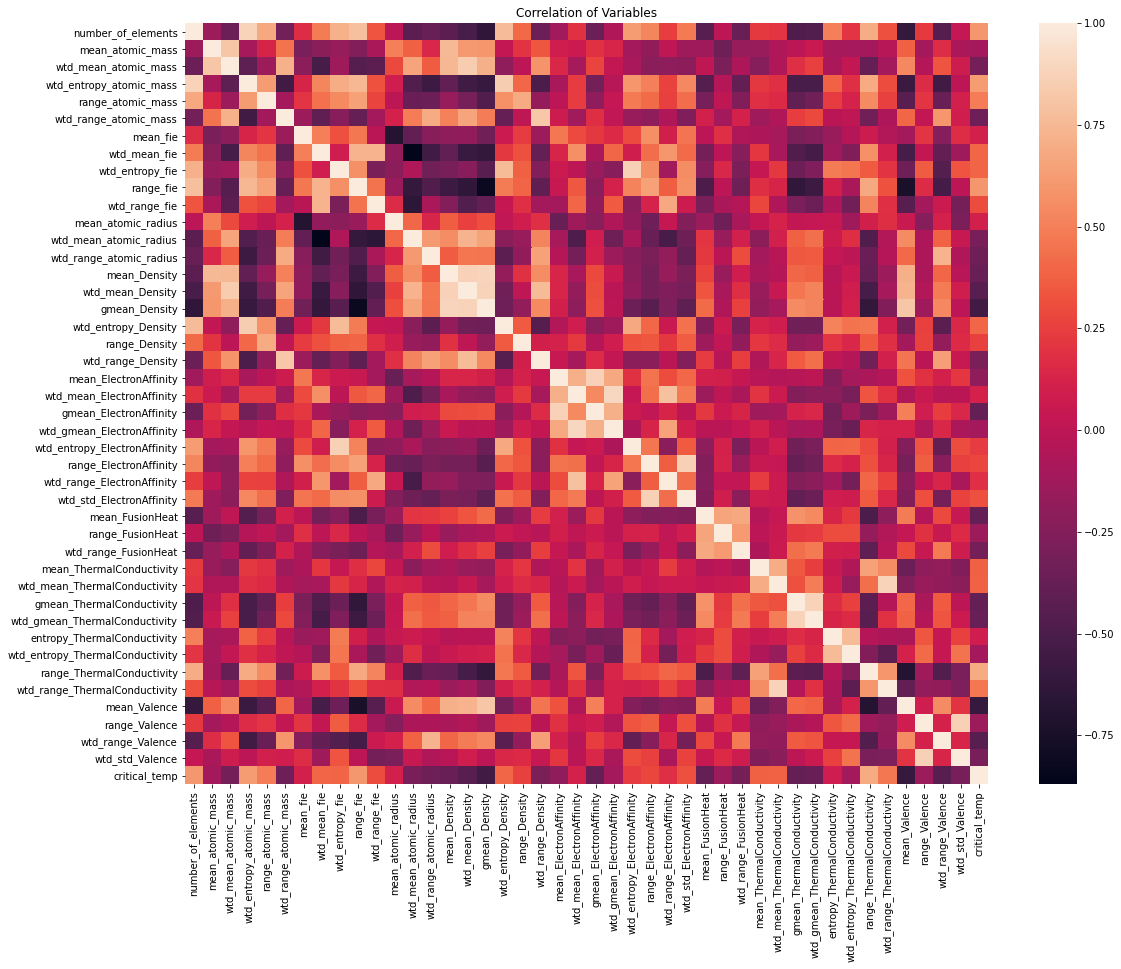

In [ ]:
df_features["critical_temp"] = df["critical_temp"]
corr = df_features.corr()
f, ax = plt.subplots(figsize = (18, 14))
plt.title("Correlation of Variables")
sns.heatmap(corr)
plt.show()
df_new = df_features
df_features = df_features.drop(["critical_temp"], axis = 1)

## Data Transformation

We want to take a look at the distribution of these 43 features and see if some need transformation to resemble a more normal distribition

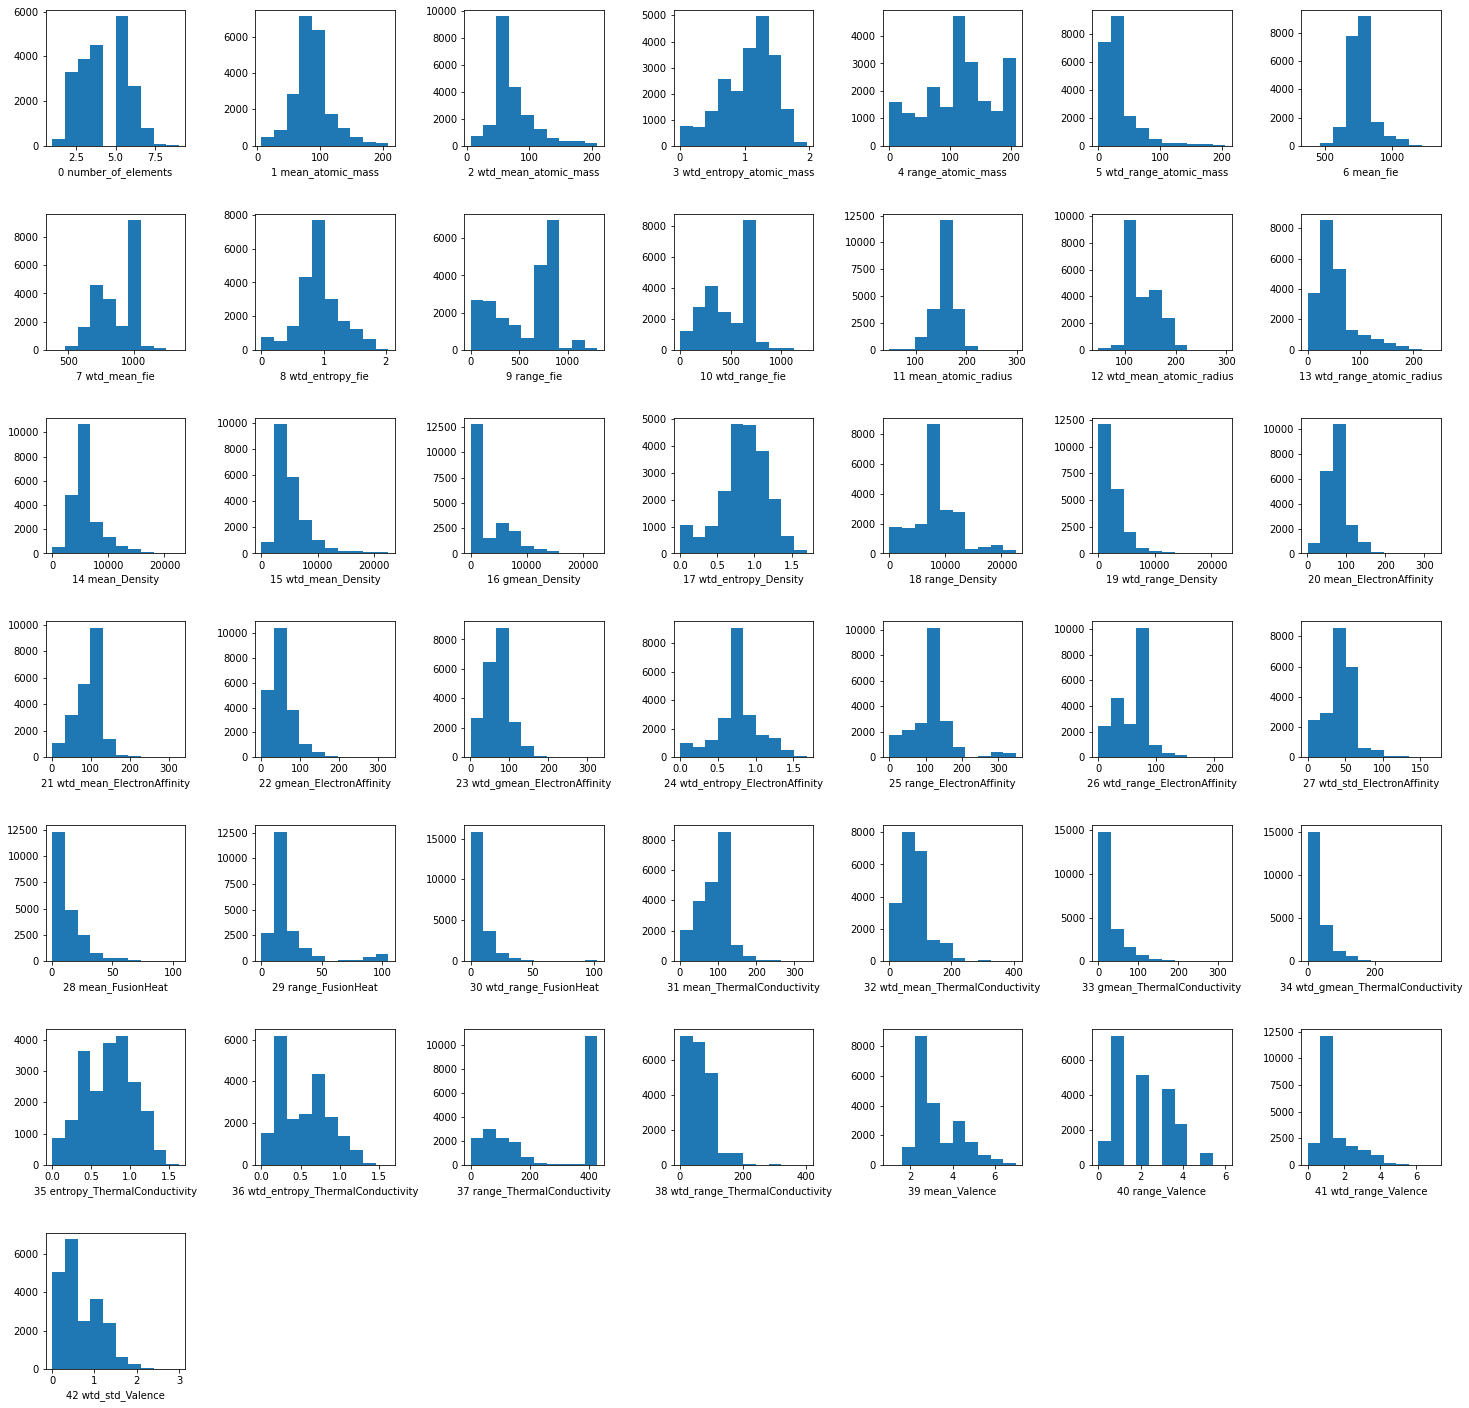

In [ ]:
# Nora
# see if some variables need transformation
variables = df_features.columns.tolist()

plt.figure(figsize=(25,25))
for i in range(43):
    plt.subplot(7,7,i+1)
    plt.grid(False)
    plt.hist(df_features[variables[i]])
    plt.xlabel(str(i) + ' ' + str(variables[i]))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

Based on the graphs above, we choose some features to perform log, square root, and box cox transformation.

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


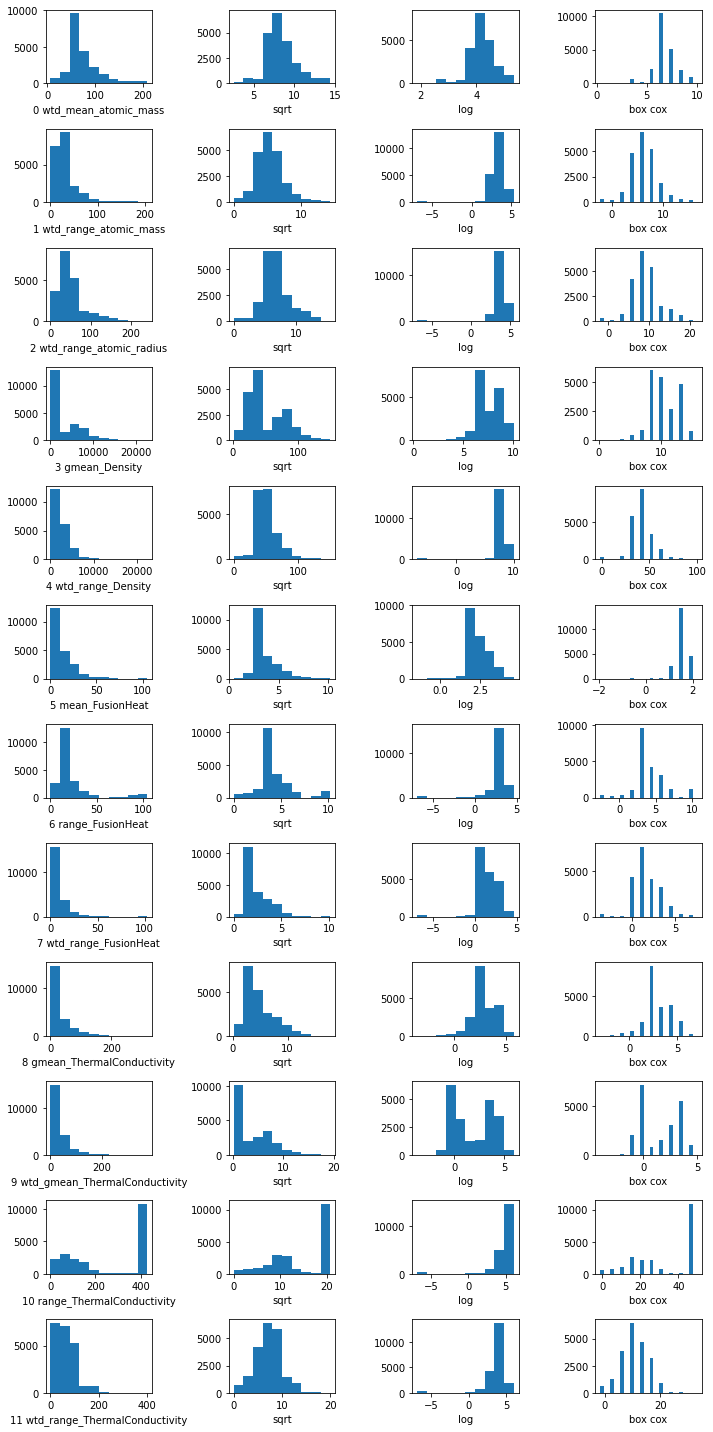

In [ ]:
# Nora
# see which ones need transformation in the previous cells
variables = pd.Series(variables)
variables_transform = variables[[2,5,13,16,19,28,29,30,33,34,37,38]].tolist()

fig, axs = plt.subplots(len(variables_transform), 4, figsize=(10,20))

for i in range(len(variables_transform)):
  axs[i,0].hist(df_features[variables_transform[i]])
  axs[i,0].set_xlabel(str(i) + ' ' + str(variables_transform[i]))
  axs[i,1].hist(np.sqrt(df_features[variables_transform[i]]))
  axs[i,1].set_xlabel('sqrt')
  axs[i,2].hist(np.log(df_features[variables_transform[i]] + 0.001))
  axs[i,2].set_xlabel('log')
  axs[i,3].hist(boxcox(df_features[variables_transform[i]] + 0.001))
  axs[i,3].set_xlabel('box cox')

fig.tight_layout()

Based on the transformed histograms above, we separate the variables into those that need square root transformation and those need log transformation, and perform transformation accordingly

In [ ]:
# from the above plots, those could use some transformation
variables_transform = pd.Series(variables_transform)

variables_sqrt = variables_transform[[0,1,4,5,6,7,10,11]].tolist()
variables_log = variables_transform[[3,8,9]].tolist()

for elem in variables_sqrt:
  df_features[elem] = np.sqrt(df_features[elem])
for elem in variables_log:
  df_features[elem] = np.sqrt(df_features[elem])

Finally, we scale the variables so that our neural network will converge faster.

In [ ]:
scaler = StandardScaler((0,1))
features = df_features

X = scaler.fit_transform(features)
Y = df['critical_temp']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2)

Let's take a final look at how the variables are like

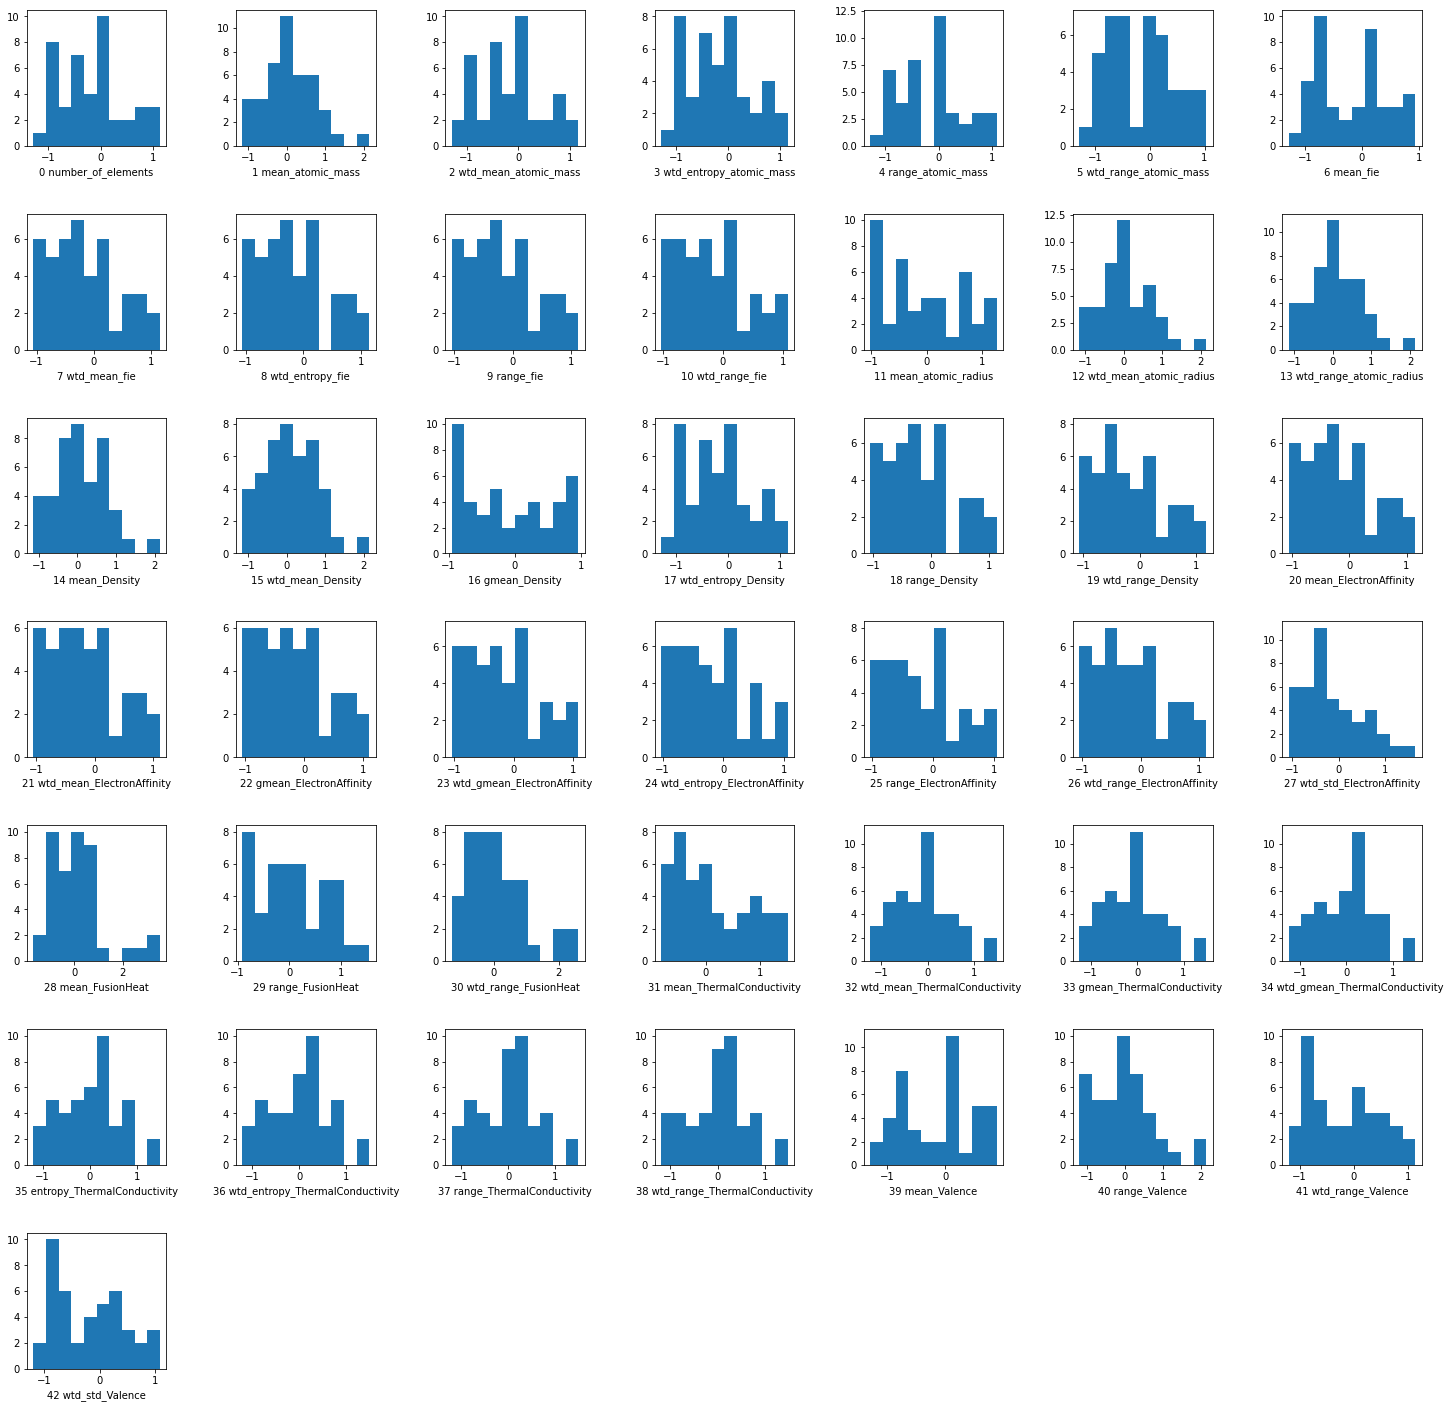

In [ ]:
# see now how the variables look like

plt.figure(figsize=(25,25))
for i in range(43):
    plt.subplot(7,7,i+1)
    plt.grid(False)
    plt.hist(X[i])
    plt.xlabel(str(i) + ' ' + str(variables[i]))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()
# looks good

Looks good! Now we can proceed to the next section, data modelling

# Modeling

We will build a regression model and evaluate its performance using the mean squared error.

We tested many different model configurations, varying parameters such as the network depth, the widths of individual layers, the presence and frequencies of dropout layers, and the use of regularization. Beyond a point, increasing the complexity of the model had the effect of reducing its performance. The model with which the best performance was achieved was a fully connected neural network with four hidden layers, the first two having a width of 200 and the next two having a width of 100. Additionally, there was a dropout layer following the second hidden layer with a frequency of 0.25. We used the ReLU activation function in each layer. Finally, the model's performance was further improved through the use of a kernel initializer function following the normal distribution. 

In [ ]:
# Everyone contributed to the model

model = models.Sequential([
    layers.Dense(200, input_dim=43, kernel_initializer='normal', activation='relu'),
    layers.Dense(200, kernel_initializer='normal', activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(100, kernel_initializer='normal', activation='relu'),
    layers.Dense(100, kernel_initializer='normal', activation='relu'),
    layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               8800      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 79,301
Trainable params: 79,301
Non-trainable params: 0
____________________________________________________

Two more features that improved the model performances are callbacks that acted on the learning rate of our neural network. Specifically, a cyclic learning rate (imported from https://github.com/bckenstler/CLR, author: Brad Kenstler) and a callback that reduced the learning rate whenever the validation loss stopped improving (reduce_lr from tensorflow).

In [ ]:
# Everyone contributed to the model
# Cyclic and reduce-on-plateau learning rates are helpful
# Could experiment more with base_lr and max_lr 
# (right now, those are the standard values)

clr_triangular = CyclicLR(mode = 'triangular2', base_lr = 0.0007, max_lr = 0.006)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4,
                              patience=5, min_lr=0.00001, verbose = 1)

checkpoint = ModelCheckpoint(filepath="weights.best", monitor='val_loss', verbose=0, save_best_only=True, mode='min')

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, Y_train, epochs = 300,
         batch_size = 15,
         verbose=2, 
         validation_data = (X_val, Y_val),
         callbacks = [reduce_lr, clr_triangular, checkpoint])

Epoch 1/300
908/908 - 3s - loss: 365.1092 - val_loss: 247.4193
INFO:tensorflow:Assets written to: weights.best/assets
Epoch 2/300
908/908 - 2s - loss: 279.1205 - val_loss: 339.9087
Epoch 3/300
908/908 - 2s - loss: 264.5938 - val_loss: 254.8947
Epoch 4/300
908/908 - 3s - loss: 212.6095 - val_loss: 195.8881
INFO:tensorflow:Assets written to: weights.best/assets
Epoch 5/300
908/908 - 2s - loss: 188.1830 - val_loss: 201.2164
Epoch 6/300
908/908 - 2s - loss: 191.2988 - val_loss: 214.9247
Epoch 7/300
908/908 - 2s - loss: 201.6719 - val_loss: 194.3528
INFO:tensorflow:Assets written to: weights.best/assets
Epoch 8/300
908/908 - 3s - loss: 187.7070 - val_loss: 190.3378
INFO:tensorflow:Assets written to: weights.best/assets
Epoch 9/300
908/908 - 2s - loss: 166.3124 - val_loss: 174.3821
INFO:tensorflow:Assets written to: weights.best/assets
Epoch 10/300
908/908 - 3s - loss: 163.4152 - val_loss: 179.0918
Epoch 11/300
908/908 - 2s - loss: 170.7383 - val_loss: 183.3155
Epoch 12/300
908/908 - 3s - lo

# Model Analysis

## General Performance

First, let's take a look at our loss function. We notice that around the 150th 
epoch, the validation loss stopped improving. However, overall, a final root mean squared error of 10.2 K for the validation set and 10.7 K on our test set are acceptable, as articles published on scientific papers report errors of around 9.5 K.

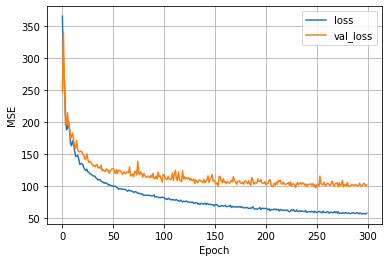

In [ ]:
# Marco, but taken from lecture

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

plot_loss(history)

Below is a table of MSE, RMSE, and $R^2$ of the three data sets. We could see that we do not have overfitting problem, which is also shown in the graph above. The $R^2$ of test sets also looks nice, very close to 1

In [ ]:
# Nora
model.load_weights("weights.best")
model.compile(optimizer='adam', loss='mse')

train_mse = model.evaluate(X_train, Y_train)
train_var = Y_train.var()

val_mse = model.evaluate(X_val, Y_val)
val_var = Y_val.var()

test_mse = model.evaluate(X_test, Y_test)
test_var = Y_test.var()

table = [['', 'MSE', 'RMSE', 'R^2'],
         ['Train', train_mse, np.sqrt(train_mse), (train_var - train_mse)/train_var],
         ['Validation', val_mse, np.sqrt(val_mse), (val_var - val_mse)/val_var],
         ['Test', test_mse, np.sqrt(test_mse), (test_var - test_mse)/test_var]]
print(tabulate(table))

133/133 [==============================] - 0s 1ms/step - loss: 111.5524
----------  ------------------  ------------------  ------------------
            MSE                 RMSE                R^2
Train       50.69070053100586   7.119740201089212   0.956589691748932
Validation  97.78343963623047   9.888550937130802   0.9146053897165232
Test        111.55237579345703  10.561835815494247  0.9081563915454458
----------  ------------------  ------------------  ------------------


Comparing the distribution below to the initial distribution of our target variable, we are satisfied with the results. In fact, the two histograms look very similar.

In [ ]:
y_pred = model.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns = ['Critical Temperature (K)'])
fig = px.histogram(y_pred_df, x = 'Critical Temperature (K)')
fig.show()

We also have a scatter plot with best fit linear regression line of predicted against observed critical temperature of test dataset. The points randomly scatter around the best fit line. From the best fit line, the neural network predicts the entire range of the critical temperature data pretty well.

In [ ]:
# Nora
fig = px.scatter(x=Y_test, y=model.predict(X_test), trendline="ols",
                 labels = {'x':'Observed Critical Temperature (K)', 'y':'Predicted Critical Temperature (K)'},
                 trendline_color_override="red")
fig.show()

One thing to note is that temperatures below 0 K are physically impossible. With further inspection, we notice that only one out of more than 4000 test predictions was below zero (-0.23 K). This is quite encouraging, as it suggests that the model learned this feature of the data very well.

In [ ]:
print('The number of test predictions below 0 is', np.count_nonzero(y_pred < 0))
print('The predicted temperature below 0 is', min(y_pred).tolist()[0])

The number of test predictions below 0 is 1
The predicted temperature below 0 is -0.2484569549560547


## Model Comparison

In this section, we want to compare our neural network model with other models. We choose a black box model, gradient boosting regressor that is meant to deliver higher accuracy, and a multiple regression model that is simpler and and more explanable.

We would compare the models based on $R^2$, MSE, RMSE, and number of negative predictions of critical temperature.

<br>

<br>

<br>

First, we have a black box model with gradient boosting regresser. As we can see that the out-of-sample $R^2$ is about 85%, below our neural network model. MSE and RMSE are also higher than our NN model.

<br>

We also plot the predicted Y_test against real Y_test. We could see that this model tend to overpredict the values critical temperature of low-temperature superconductors. Especially in the 0-50 K critical temperature zone, we have more observations above the best fit line than below.

<br>

The number of negative prediction is also higher than that of our NN model.

In [ ]:
# Nora
# black box
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor

model2 = GradientBoostingRegressor()

# fit model to training data
model2.fit(X_train, Y_train)

train_mse_2 = mean_squared_error(Y_train, model2.predict(X_train))

val_mse_2 = mean_squared_error(Y_val, model2.predict(X_val))

test_mse_2 = mean_squared_error(Y_test, model2.predict(X_test))

table_2 = [['', 'MSE', 'RMSE', 'R^2'],
         ['Train', train_mse_2, np.sqrt(train_mse_2), model2.score(X_train, Y_train)],
         ['Validation', val_mse_2, np.sqrt(val_mse_2), model2.score(X_val, Y_val)],
         ['Test', test_mse_2, np.sqrt(test_mse_2), model2.score(X_val, Y_val)]]
print(tabulate(table_2))

print('The number of test predictions below 0 is', np.count_nonzero(model2.predict(X_test) < 0))

fig = px.scatter(x=Y_test, y=model2.predict(X_test), trendline="ols",
                 labels = {'x':'Observed Critical Temperature (K)', 'y':'Predicted Critical Temperature (K)'},
                 trendline_color_override="red",
                 title="Gradient Boosting Regressor")
fig.show()

----------  ------------------  ------------------  ------------------
            MSE                 RMSE                R^2
Train       154.1050189401377   12.41390425853759   0.8680184344423961
Validation  180.65565834671753  13.440820597966388  0.8421864108892668
Test        176.94426812275037  13.302039998539712  0.8421864108892668
----------  ------------------  ------------------  ------------------
The number of test predictions below 0 is 23


Next we also build a multiple linear regression model (MLR). From all of $R^2$, MSE and RMSE, our NN model perform better than this MLR model.

<br>

From the scatter plot of predicted against real Y_test critical temperature directly, this model gave multiple negative value of predicted critical temperature, which indicates that this model would not explain the relationship between critical temperature and the various features of superconductors pretty well

In [ ]:
# Nora

from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X_test, Y_test)

train_mse_regr = mean_squared_error(Y_train, regr.predict(X_train))

val_mse_regr = mean_squared_error(Y_val, regr.predict(X_val))

test_mse_regr = mean_squared_error(Y_test, regr.predict(X_test))

table_regr = [['', 'MSE', 'RMSE', 'R^2'],
         ['Train', train_mse_regr, np.sqrt(train_mse_regr), regr.score(X_train, Y_train)],
         ['Validation', val_mse_regr, np.sqrt(val_mse_regr), regr.score(X_val, Y_val)],
         ['Test', test_mse_regr, np.sqrt(test_mse_regr), regr.score(X_val, Y_val)]]
print(tabulate(table_regr))

fig = px.scatter(x=Y_test, y=regr.predict(X_test), trendline="ols",
                 labels = {'x':'Observed Critical Temperature (K)', 'y':'Predicted Critical Temperature (K)'},
                 trendline_color_override="red",
                 title="Multiple Linear Regression")
fig.show()

----------  ------------------  ------------------  ------------------
            MSE                 RMSE                R^2
Train       367.216175383747    19.162885361650186  0.6855017048857497
Validation  371.89776356768346  19.28465098381828   0.6751249233598258
Test        363.5302223426145   19.06646853359621   0.6751249233598258
----------  ------------------  ------------------  ------------------


By comparing our NN model to gradient boosting regressor and MLR model, we could see that our NN model give a more promising result in terms of $R^2$, error, as well as number of negative predictions. 

## Model Interpretability
In this section, we aim to interpret the the results obtained above based on some of the features we are interested in in the above sections, namely number of elements, density, and thermal conductivity, which are features that we think are most related to the variation in critical temperature.

We have shown in the previous data visualization section that number of elements, weighted mean density, and weighted mean thermal conductivity are pretty correlated with critical temperature. After modelling, we want to double check how much they contribute to the variation of critical temperature. We do so by looking at Individual Conditional Expectations(ICE) plots for our neural network model.



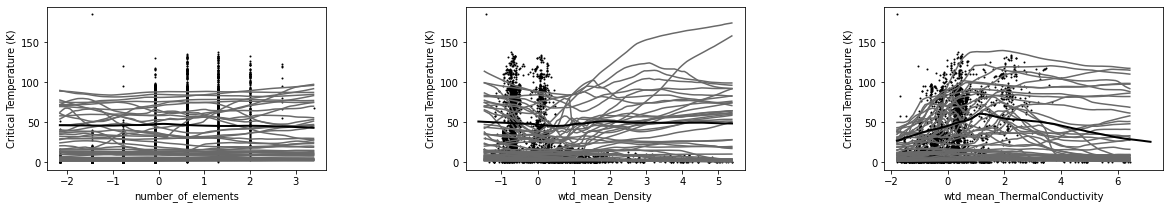

In [ ]:
# Nora
feature_idx = [0, 15, 32] # number_of_elements, wtd_mean_Density, wtd_mean_Thermal_Conductivity

sample_idx_list = np.arange(50)
plt.figure(figsize=(20,3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.grid(False)

    for sample_idx in sample_idx_list:
      feature_vals, pred_y = myICE(X_test, model, feature_idx = feature_idx[i], sample_idx = sample_idx)
      plt.plot(feature_vals, pred_y, 'dimgray')

    feature_vals, PD = my_Partial_Dependence(X, model, feature_idx[i], sample_idx_list)
    plt.plot(feature_vals, PD, 'k', linewidth=2)
	

    plt.scatter(X_test[:, feature_idx[i]], Y_test, c='k', s = 1)
    plt.ylabel("Critical Temperature (K)")
    plt.xlabel(str(df_features.columns.tolist()[feature_idx[i]]))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()


Unfortunately, critical temperature do not seem fo highly depend on number of elements. But critical temperature do seem of vary when weighted mean density and weighted mean thermal conductivity varies, indicating that these two features have some influence on critical temperature.

## Feature Importance

In this section, we want to take a look at feature importance of all 43 variables. We assessed the importance of the features in prediction mean absolute error. We found that the highest relative influence is attributed to variables extracted from the thermal conductivity, electron affinity, and density of the materials.

<br>

The histogram below shows the feature importance of all 43 variables.

In [ ]:
# Nora

def score_func(X, y):
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)

base_score, score_decreases = get_score_importances(score_func, X_test, Y_test)
feature_importances = np.mean(score_decreases, axis=0)

d = {'feature' : df_features.columns.tolist(),
     'feature_importance' : [-elem for elem in feature_importances]}
df_importance = pd.DataFrame(d)
df_importance = df_importance.sort_values(by = ['feature_importance'], ascending = False, ignore_index = True)

fig = px.bar(df_importance, x='feature', y='feature_importance', labels = {'feature_importance' : 'Feature importance',
                                                                           'feature':'Feature'})
fig.show()

Below we group the variables by their nature and plot a pie chart to the ratio of feature importance among the different variables

In [ ]:
# Nora
df_importance_group = df_importance.copy()
for i in range(len(df_importance)):
  df_importance_group['feature'][i] = df_importance_group['feature'][i].split('_')[-1]

df_importance_group = df_importance_group.replace('mass', 'Atomic Mass')
df_importance_group = df_importance_group.replace('radius', 'Atomic Radius')
df_importance_group = df_importance_group.replace('fie', 'Fie')
df_importance_group_sum = df_importance_group.groupby(['feature']).sum()
df_importance_group_sum = df_importance_group_sum.reset_index()
fig = px.pie(df_importance_group_sum, values='feature_importance', names='feature', title='Grouped Feature Importance')
fig.update_layout(
    title={
        'text': "Grouped Feature Importance",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-0.3,
    xanchor="right",
    x=0.9
))
fig.show()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


It is obvious from this graph that our most significant features would be attributes related to **Thermal Conductivity, Electron Affinity**, and **Density**

# Conclusion

In our project, we have shown that the neural network model can predict critical temperature reaosnably well with $R^2$ above 90%. The most influential attributes are related to thermal conductivity, electron affinity, and density. Such a models could be used to guide a search for new superconductors synthesized from specific known features.

In this process, we learned that predicting the critical temperature of super conductors requires many different features that are associated with chemical properties such as Thermal Conductivity and Electorn Affinity of elements. Initially, we thought that one or two measurements for each one of these chemical properties (e.g., mean and standard deviation) would have been the best way to go. In the end, however, we found out that it was better to keep many more features (e.g. geometric mean, weighted mean, etc.) so that our model could learn faster. 

Additionally, we noticed that scaling and normalizing (Standard Scaler) our data was much more effective than just scaling (MinMaxScaler) it. 

Furthermore, we tried to build a very deep model and to implement batch normalization. However, we noticed that both these ideas did not improve the performance of the model. 

To conclude, it was interesting to explore some aspects of superconductors, like their distribution and the correlation of their critical temperature with some of their variables.

In the end, a out-of-sample root mean squared error of around 10 K is a satisfying result for us. 